In [12]:
import numpy as np
import scipy as sp
import pandas as pd 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

In [13]:
class My_NGBoost(object):
    def __init__(self, n_estimators = 1000, learning_rate = 0.01):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.init_params = None
        self.base_models = list()
        self.scalings = list()

    def boost(self, X, grads):
        models = [DecisionTreeRegressor(max_depth = 3).fit(X, g) for g in grads.T]
        self.base_models.append(models)
        return np.array([m.predict(X) for m in models]).T
    
    def predict(self, X):
        params = np.ones((X.shape[0], 2)) * self.init_params
        for i, (models, s) in enumerate(zip(self.base_models, self.scalings)):
            params -= self.learning_rate * np.array([model.predict(X) for model in models]).T * s
        return list(np.asarray(params).T[0].flatten())
    
    def line_search(self, resids, start, Y):
        scale = 1
        loss_init = -sp.stats.norm(loc = start.T[0], scale = np.exp(start.T[1])).logpdf(Y.squeeze()).mean()
        loss = -sp.stats.norm(loc = (start - resids).T[0], scale = np.exp((start - resids).T[1])).logpdf(Y.squeeze()).mean()

        while np.isnan(loss) or (loss >= loss_init and np.mean(np.linalg.norm(resids, axis=1)) >= 1e-6) or np.linalg.norm(resids, axis=1).mean() >= 5.0:
            scale /= 2
            resids /= 2
            loss = -sp.stats.norm(loc = (start - resids).T[0], scale = np.exp((start - resids).T[1])).logpdf(Y.squeeze()).mean()
            
        self.scalings.append(scale)
        return scale
    
    def fit(self, X, Y):
        m, s = sp.stats.norm.fit(Y)
        self.init_params = np.array([m, np.log(s)])

        params = np.ones((X.shape[0], 2)) * self.init_params
        for i, (models, s) in enumerate(zip(self.base_models, self.scalings)):
            params -= self.learning_rate * np.array([model.predict(X) for model in models]).T * s

        for i in range(self.n_estimators):
            loc = params.T[0]
            var = np.exp(params.T[1]) ** 2
        
            loss = -sp.stats.norm(loc = loc, scale = np.exp(params.T[1])).logpdf(Y.squeeze()).mean()
            
            fisher = np.zeros((var.shape[0], 2, 2))
            fisher[:, 0, 0] = 1 / var + 1e-6
            fisher[:, 1, 1] = 2
            
            grads = np.zeros((len(Y), 2))
            grads[:, 0] = (loc - Y) / var
            grads[:, 1] = 1 - ((loc - Y) ** 2) / var
            grads = np.linalg.solve(fisher, grads)
    
            proj_grad = self.boost(X, grads)
            scale = self.line_search(proj_grad, params, Y)

            params -= self.learning_rate * scale * np.array([m.predict(X) for m in self.base_models[-1]]).T

            if i % 100 == 0 or i == self.n_estimators - 1 or np.linalg.norm(proj_grad, axis=1).mean() < 1e-6:
                grad_norm = np.linalg.norm(grads, axis=1).mean() * scale
                print(f"iter = {i + 1},\t loss = {loss},\t scale = {scale},\t grad_norm = {grad_norm}")
                if np.linalg.norm(proj_grad, axis=1).mean() < 1e-6:
                    break
        return self

In [14]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [15]:
# Normal Distribution
X = np.random.rand(1000, 10)
w_mu = np.random.rand(10)
w_sigma = np.random.rand(10)
mu = np.dot(X, w_mu)
sigma = np.dot(X, w_sigma) # 对数正态分布
Y = np.random.rand(1000) * sigma + mu

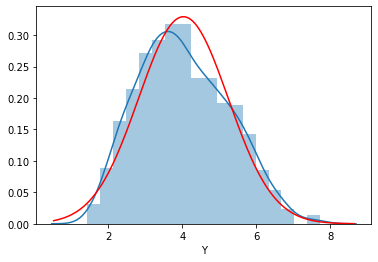

In [16]:
sns.distplot(Y, kde = True, fit = stats.norm, fit_kws = {'color':'r'}, axlabel = "Y")

In [17]:
Xp = pd.DataFrame(X)
Xp['10'] = Y
tr, te = train_test_split(Xp, test_size = 0.2, random_state = 1)

y_tr = np.asarray(tr['10'])
tr = np.asarray(tr.drop(['10'], 1))
y_te =  np.asarray(te['10'])
te = np.asarray(te.drop(['10'], 1))

In [18]:
boost = My_NGBoost(n_estimators = 10000)
boost.fit(tr, y_tr)

iter = 1,	 loss = 1.5970815915908319,	 scale = 1,	 grad_norm = 1.1442533847075165
iter = 101,	 loss = 1.3924148444742372,	 scale = 1,	 grad_norm = 0.9599499607009426
iter = 201,	 loss = 1.2575576285438128,	 scale = 1,	 grad_norm = 0.8714581344291414
iter = 301,	 loss = 1.1543041516440404,	 scale = 1,	 grad_norm = 0.816300950871107
iter = 401,	 loss = 1.071871836207619,	 scale = 1,	 grad_norm = 0.7766374326798029
iter = 501,	 loss = 1.0030625511707194,	 scale = 1,	 grad_norm = 0.7463283964340272
iter = 601,	 loss = 0.9463222132327754,	 scale = 1,	 grad_norm = 0.7222834490955802
iter = 701,	 loss = 0.8993700376220707,	 scale = 1,	 grad_norm = 0.7044796737236086
iter = 801,	 loss = 0.8587690409277843,	 scale = 1,	 grad_norm = 0.6898640733355933
iter = 901,	 loss = 0.8261344885304694,	 scale = 1,	 grad_norm = 0.67903548879139
iter = 1001,	 loss = 0.7943666462331571,	 scale = 1,	 grad_norm = 0.6681918332616634
iter = 1101,	 loss = 0.763852953211136,	 scale = 1,	 grad_norm = 0.65785782636265

In [19]:
rmsle(y_te, boost.predict(np.array(te)))

1.0011817983211273

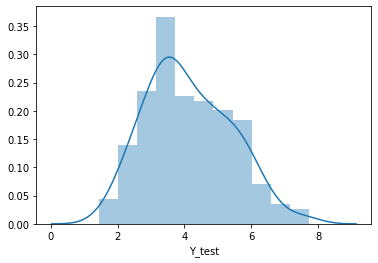

In [20]:
sns.distplot(y_te, axlabel = "Y_test")

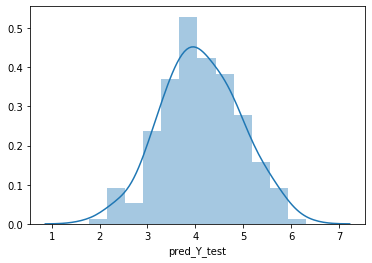

In [21]:
sns.distplot(boost.predict(np.array(te)), axlabel = "pred_Y_test")

In [22]:
boost = NGBoost(n_estimators = 10000)
boost.fit(tr, y_tr)

[iter 0] loss=1.5971 val_loss=0.0000 scale=1.0000 norm=1.1442
[iter 100] loss=1.3924 val_loss=0.0000 scale=1.0000 norm=0.9599
[iter 200] loss=1.2576 val_loss=0.0000 scale=1.0000 norm=0.8715
[iter 300] loss=1.1543 val_loss=0.0000 scale=1.0000 norm=0.8163
[iter 400] loss=1.0719 val_loss=0.0000 scale=1.0000 norm=0.7766
[iter 500] loss=1.0031 val_loss=0.0000 scale=1.0000 norm=0.7463
[iter 600] loss=0.9463 val_loss=0.0000 scale=1.0000 norm=0.7223
[iter 700] loss=0.8994 val_loss=0.0000 scale=1.0000 norm=0.7045
[iter 800] loss=0.8588 val_loss=0.0000 scale=1.0000 norm=0.6899
[iter 900] loss=0.8262 val_loss=0.0000 scale=1.0000 norm=0.6790
[iter 1000] loss=0.7944 val_loss=0.0000 scale=1.0000 norm=0.6682
[iter 1100] loss=0.7638 val_loss=0.0000 scale=1.0000 norm=0.6577
[iter 1200] loss=0.7331 val_loss=0.0000 scale=1.0000 norm=0.6474
[iter 1300] loss=0.7052 val_loss=0.0000 scale=1.0000 norm=0.6389
[iter 1400] loss=0.6769 val_loss=0.0000 scale=1.0000 norm=0.6296
[iter 1500] loss=0.6538 val_loss=0.00

In [23]:
rmsle(y_te, boost.predict(np.array(te)))

1.0319492645127755

In [24]:
X = np.random.rand(1000, 10)
w_mu = np.random.rand(10)
w_sigma = np.random.rand(10)
mu = np.dot(X, w_mu)
sigma = np.exp(np.dot(X, w_sigma)) # Lognormal Distribution
Y = np.random.rand(1000) * sigma + mu

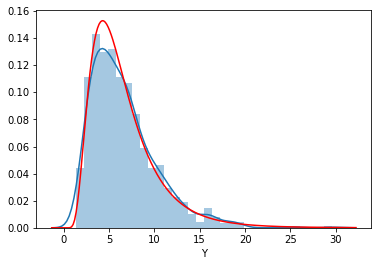

In [25]:
sns.distplot(Y, kde = True, fit = stats.lognorm, fit_kws = {'color':'r'}, axlabel = "Y")

In [26]:
Xp = pd.DataFrame(X)
Xp['10'] = Y
tr, te = train_test_split(Xp, test_size = 0.2, random_state = 1)

y_tr = np.asarray(tr['10'])
tr = np.asarray(tr.drop(['10'], 1))
y_te =  np.asarray(te['10'])
te = np.asarray(te.drop(['10'], 1))

In [27]:
boost = My_NGBoost(n_estimators = 10000)
boost.fit(tr, y_tr)

iter = 1,	 loss = 2.6801127697002203,	 scale = 1,	 grad_norm = 2.8457134668713993
iter = 101,	 loss = 2.4115942703042426,	 scale = 1,	 grad_norm = 2.384663600220025
iter = 201,	 loss = 2.271669245416992,	 scale = 1,	 grad_norm = 2.1748490050910623
iter = 301,	 loss = 2.1669423621649924,	 scale = 1,	 grad_norm = 2.0358194547020347
iter = 401,	 loss = 2.086409355712939,	 scale = 1,	 grad_norm = 1.9366592524679114
iter = 501,	 loss = 2.0242186923717735,	 scale = 1,	 grad_norm = 1.8606003275132341
iter = 601,	 loss = 1.9804322220469168,	 scale = 1,	 grad_norm = 1.8060419271387815
iter = 701,	 loss = 1.942361306599624,	 scale = 1,	 grad_norm = 1.760345418086324
iter = 801,	 loss = 1.908571107707452,	 scale = 1,	 grad_norm = 1.717826312324756
iter = 901,	 loss = 1.8781062870624026,	 scale = 1,	 grad_norm = 1.679505470336781
iter = 1001,	 loss = 1.8505935575743597,	 scale = 1,	 grad_norm = 1.6444118789725823
iter = 1101,	 loss = 1.8238236995126988,	 scale = 1,	 grad_norm = 1.6086614448447702


In [28]:
rmsle(y_te, boost.predict(np.array(te)))

3.334719603448596

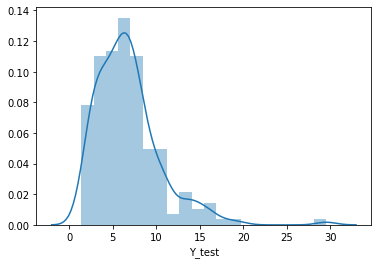

In [29]:
sns.distplot(y_te, axlabel = "Y_test")

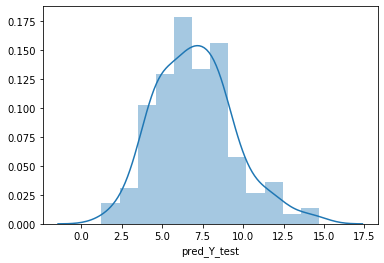

In [30]:
sns.distplot(boost.predict(np.array(te)), axlabel = "pred_Y_test")

In [31]:
boost = NGBoost(n_estimators = 10000)
boost.fit(tr, y_tr)

[iter 0] loss=2.6801 val_loss=0.0000 scale=1.0000 norm=2.8454
[iter 100] loss=2.4116 val_loss=0.0000 scale=1.0000 norm=2.3844
[iter 200] loss=2.2717 val_loss=0.0000 scale=1.0000 norm=2.1747
[iter 300] loss=2.1671 val_loss=0.0000 scale=1.0000 norm=2.0357
[iter 400] loss=2.0866 val_loss=0.0000 scale=1.0000 norm=1.9369
[iter 500] loss=2.0243 val_loss=0.0000 scale=1.0000 norm=1.8595
[iter 600] loss=1.9812 val_loss=0.0000 scale=1.0000 norm=1.8062
[iter 700] loss=1.9425 val_loss=0.0000 scale=1.0000 norm=1.7592
[iter 800] loss=1.9097 val_loss=0.0000 scale=1.0000 norm=1.7181
[iter 900] loss=1.8800 val_loss=0.0000 scale=1.0000 norm=1.6808
[iter 1000] loss=1.8532 val_loss=0.0000 scale=0.5000 norm=0.8230
[iter 1100] loss=1.8279 val_loss=0.0000 scale=1.0000 norm=1.6130
[iter 1200] loss=1.8015 val_loss=0.0000 scale=0.5000 norm=0.7891
[iter 1300] loss=1.7789 val_loss=0.0000 scale=1.0000 norm=1.5473
[iter 1400] loss=1.7542 val_loss=0.0000 scale=1.0000 norm=1.5179
[iter 1500] loss=1.7258 val_loss=0.00

In [32]:
rmsle(y_te, boost.predict(np.array(te)))

3.351472288925565